In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn.modules.loss import *
from Loss.triplet import *
from session import *
from LR_Schedule.cyclical import Cyclical
from LR_Schedule.cos_anneal import CosAnneal
from LR_Schedule.lr_find import lr_find
from callbacks import *
from validation import *
from validation import _AccuracyMeter
import Datasets.ImageData as ImageData
from Transforms.ImageTransforms import *
import util
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from torch.utils.tensorboard import SummaryWriter
from session import LossMeter, EvalModel
# %matplotlib notebook

/home/drake/anaconda3/envs/.torch/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/drake/anaconda3/envs/.torch/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/drake/anaconda3/envs/.torch/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/drake/anaconda3/envs/.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
torch.cuda.set_device(0); torch.backends.cudnn.benchmark=True;

/home/drake/anaconda3/envs/.torch/lib/python3.7/site-packages/torch/cuda/__init__.py:135: UserWarning: 
    Found GPU0 GeForce GTX 770 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


In [4]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

fulltrainset = datasets.MNIST('/media/drake/MX500/Datasets/mnist/train', download=True, train=True, transform=transform)
trainset = torch.utils.data.dataset.Subset(fulltrainset, np.arange(2500))

fullvalset = datasets.MNIST('/media/drake/MX500/Datasets/mnist/test', download=True, train=False, transform=transform)
valset = torch.utils.data.dataset.Subset(fullvalset, np.arange(5000))

trainloader = torch.utils.data.DataLoader(fulltrainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(fullvalset, batch_size=64, shuffle=False)

In [5]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [6]:
class TripletRegularizedCrossEntropyLoss(nn.Module):
    def __init__(self, alpha, margin):     
        super().__init__()
        self.alpha = alpha
        self.margin = margin
        
    def forward(self, x, y):
        loss = F.cross_entropy(x[-1][0], y)
        triplet = 0
        if (self.alpha > 0):
            for layer in x[:-1]:
                # print(layer[0])
                triplet += batch_hard_triplet_loss(layer[0].view(layer[0].size(0), -1), y, self.margin)

            triplet *= self.alpha
            
        return loss + triplet

In [7]:
class CustomOneHotAccuracy(OneHotAccuracy):
    def __init__(self):
        super().__init__()
        self.reset()

    def update(self, output, label):
        return super().update(output[-1][0], label)

In [8]:
class EmbeddingSpaceValidator(TrainCallback):
    def __init__(self, val_data, num_embeddings, accuracy_meter_fn):
        self.val_data = val_data
        self.val_accuracy_meter = accuracy_meter_fn()
        self.train_accuracy_meter = accuracy_meter_fn()
        self.num_embeddings=num_embeddings
        
        self.train_accuracies = []
        self.batch_train_accuracies = []
        self.val_accuracies = []
        
        self.train_losses = []
        self.batch_train_losses = []
        self.train_bce_losses = []
        self.val_losses = []
        self.val_bce_losses = []
        
        self.batch_train_embedding_losses = [[] for x in range(self.num_embeddings)]
        self.val_embedding_losses = [[] for x in range(self.num_embeddings)]
        
        self.num_batches = 0
        self.num_epochs = 0
        
        self.epochs = []

    def run(self, session, lossMeter=None):
        self.val_accuracy_meter.reset()
            
        val_loss = LossMeter()
        val_bce_loss = LossMeter()
        embedding_losses = [LossMeter() for x in range(self.num_embeddings)]
        
        with EvalModel(session.model):
            for input, label, *_ in tqdm(self.val_data, desc="Validating", leave=True):
                label = Variable(util.to_gpu(label))
                output = session.forward(input)
                
                step_loss = session.criterion(output, label).data.cpu()
                
                val_loss.update(step_loss, input.shape[0])
                
                val_bce_loss.update(F.cross_entropy(output[-1][0], label).data.cpu(), input.shape[0])
                
                self.val_accuracy_meter.update(output, label)
                    
                for layer, embedding_loss in zip(output[:-1], embedding_losses):
                    embedding_loss.update(batch_all_triplet_loss(layer[0].view(layer[0].size(0), -1), label, 1).data.cpu())
        
        self.val_losses.append(val_loss.raw_avg.item())
        self.val_bce_losses.append(val_bce_loss.raw_avg.item())
         
        accuracy = self.val_accuracy_meter.accuracy()
        
        self.val_accuracies.append(accuracy)
              
        for meter, loss in zip(embedding_losses, self.val_embedding_losses):
            loss.append(meter.raw_avg)     
        
    def on_epoch_begin(self, session):
        self.train_accuracy_meter.reset()     
        self.train_bce_loss_meter = LossMeter()
        
    def on_epoch_end(self, session, lossMeter): 
        self.train_accuracies.append(self.train_accuracy_meter.accuracy())
        self.train_losses.append(lossMeter.debias.data.cpu().item())
        
        self.train_bce_losses.append(self.train_bce_loss_meter.raw_avg.data.cpu().item())
        
        self.run(session, lossMeter) 
        self.epochs.append(self.num_batches)
        self.num_epochs += 1
        
        print("\nval accuracy: ", round(self.val_accuracies[-1], 4),
              "\ntrain loss: ", round(self.train_losses[-1], 4) , 
              " train BCE : ", round(self.train_bce_losses[-1], 4) ,       
              "\nvalid loss: ", round(self.val_losses[-1], 4), 
              " valid BCE : ", round(self.val_bce_losses[-1], 4))
    
    def on_batch_end(self, session, lossMeter, output, label):
        label = Variable(util.to_gpu(label))
        batch_accuracy = self.train_accuracy_meter.update(output, label)
        self.batch_train_accuracies.append(batch_accuracy)
        self.batch_train_losses.append(lossMeter.loss.data.cpu().item())   
        self.train_bce_loss_meter.update(F.cross_entropy(output[-1][0], label).data.cpu(), label.shape[0])
             
        for layer, embedding_loss in zip(output[:-1], self.batch_train_embedding_losses):
            embedding_loss.append(batch_all_triplet_loss(layer[0].view(layer[0].size(0), -1), label, 1).data.cpu().item())
            
        self.num_batches += 1
            
    def plot(self):
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, figsize=(15, 15))
        
        #ax.plot(np.arange(self.num_batches), self.batch_train_accuracies)
        #legend.append("Train accuracy per batch")
        
        #ax.plot(np.arange(self.num_batches), self.batch_train_losses)
        #legend.append("Train loss per batch")
            
        ax1.plot(self.epochs, self.train_accuracies, '-o', label="Training accuracy per epoch")

        ax1.plot(self.epochs, self.val_accuracies, '-o', label="Validation accuracy per epoch")
        
        ax2.plot(self.epochs, self.train_losses, '-o', label="Training loss per epoch")
        
        ax2.plot(self.epochs, self.val_losses, '-o', label="Validation loss per epoch")
        
        ax3.plot(self.epochs, self.train_bce_losses, '-o', label="Training BCE loss per epoch")
        
        ax3.plot(self.epochs, self.val_bce_losses, '-o', label="Validation BCE loss per epoch")
        
        for embedding in self.batch_train_embedding_losses:
            ax4.plot(np.arange(self.num_batches), embedding, label="Train embedding triplet loss per batch")
        
        for embedding in self.val_embedding_losses:
            ax4.plot(self.epochs, embedding, '-o', label="Validation embedding triplet loss per epoch")
            
        for ax in (ax1, ax2, ax3, ax4):
            box = ax.get_position()
            ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [9]:
class SelectiveSequential(nn.Module):
    def __init__(self, to_select, modules_dict):
        super(SelectiveSequential, self).__init__()
        for key, module in modules_dict.items():
            self.add_module(key, module)
        self._to_select = to_select
    
    def forward(self, x):
        list = []
        for name, module in self._modules.items():
            x = module(x)
            if name in self._to_select:
                list.append((x, name))
        return list
    
model = SelectiveSequential(
    ['act3', 'out'],
    {#'conv32a': nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
     #'batch32a': nn.BatchNorm2d(32),
     #'act32a': nn.ReLU(),
    
     #'conv32b': nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
     #'batch32b': nn.BatchNorm2d(32),
     #'act32b': nn.ReLU(),
     
     #'max1': nn.MaxPool2d(kernel_size=2, stride=2),
    
     #'conv64a': nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
     #'batch64a': nn.BatchNorm2d(64),
     #'act64a': nn.ReLU(),
     
     #'conv64b': nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
     #'batch64b': nn.BatchNorm2d(64),
     #'act64b': nn.ReLU(),
    
     #'max2': nn.MaxPool2d(kernel_size=2, stride=2),
    
     #'conv128a': nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
     #'batch128a': nn.BatchNorm2d(128),
     #'act128a': nn.ReLU(),
     
     #'conv128b': nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
     # 'batch128b': nn.BatchNorm2d(128),
     #'act128b': nn.ReLU(),
     
     # 'max3': nn.MaxPool2d(kernel_size=2, stride=2),
    
     'flatten': Flatten(),
    
     'fc1': nn.Linear(784, 100),
     'act1': nn.ReLU(),
     #'drop1': nn.Dropout(.05),
        
     'fc2': nn.Linear(100, 200),  
     'act2': nn.ReLU(),
        
     'fc3': nn.Linear(200, 200),  
     'act3': nn.ReLU(),
        
     'fc4': nn.Linear(200, 100),  
     'act4': nn.ReLU(),
        
     'fc5': nn.Linear(100, 50),  
     'act5': nn.ReLU(),
        
     #'drop1': nn.Dropout(.05),
     'out': nn.Linear(50, 10)})

In [10]:
criterion = TripletRegularizedCrossEntropyLoss(0, 1)

In [11]:
sess = Session(model, criterion, optim.Adam, 1e-3)

In [12]:
# lr_find(sess, trainloader, start_lr=1e-12)

In [13]:
sess.set_lr(1e-3)

In [14]:
validator = EmbeddingSpaceValidator(valloader, 1, CustomOneHotAccuracy)
lr_scheduler = CosAnneal(len(trainloader), T_mult=1, lr_min=1e-6)
schedule = TrainingSchedule(trainloader, [lr_scheduler, validator])
sess.train(schedule, 63)

Validating: 100%|██████████| 157/157 [00:02<00:00, 69.58it/s]


val accuracy:  0.9219 
train loss:  0.2723  train BCE :  0.4486 
valid loss:  0.2498  valid BCE :  0.2498


Validating: 100%|██████████| 157/157 [00:02<00:00, 69.69it/s]


val accuracy:  0.9488 
train loss:  0.1702  train BCE :  0.2288 
valid loss:  0.1656  valid BCE :  0.1656


Validating: 100%|██████████| 157/157 [00:02<00:00, 69.20it/s]


val accuracy:  0.9611 
train loss:  0.1331  train BCE :  0.1695 
valid loss:  0.1302  valid BCE :  0.1302


Validating: 100%|██████████| 157/157 [00:02<00:00, 69.64it/s]


val accuracy:  0.9657 
train loss:  0.1223  train BCE :  0.1377 
valid loss:  0.1109  valid BCE :  0.1109


Validating: 100%|██████████| 157/157 [00:02<00:00, 66.37it/s]


val accuracy:  0.9704 
train loss:  0.0835  train BCE :  0.1203 
valid loss:  0.0986  valid BCE :  0.0986


Validating: 100%|██████████| 157/157 [00:02<00:00, 69.98it/s]


val accuracy:  0.9716 
train loss:  0.0817  train BCE :  0.1015 
valid loss:  0.0922  valid BCE :  0.0922


Validating: 100%|██████████| 157/157 [00:02<00:00, 69.37it/s]


val accuracy:  0.9744 
train loss:  0.069  train BCE :  0.0958 
valid loss:  0.0878  valid BCE :  0.0878


Validating: 100%|██████████| 157/157 [00:02<00:00, 64.25it/s]


val accuracy:  0.9743 
train loss:  0.0767  train BCE :  0.0862 
valid loss:  0.0813  valid BCE :  0.0813


Validating: 100%|██████████| 157/157 [00:02<00:00, 67.69it/s]


val accuracy:  0.9782 
train loss:  0.0593  train BCE :  0.0799 
valid loss:  0.0768  valid BCE :  0.0768


Validating: 100%|██████████| 157/157 [00:02<00:00, 69.60it/s]


val accuracy:  0.9774 
train loss:  0.0509  train BCE :  0.0719 
valid loss:  0.0757  valid BCE :  0.0757


Validating: 100%|██████████| 157/157 [00:02<00:00, 70.13it/s]


val accuracy:  0.9789 
train loss:  0.0458  train BCE :  0.0692 
valid loss:  0.0735  valid BCE :  0.0735


Validating: 100%|██████████| 157/157 [00:02<00:00, 69.25it/s]


val accuracy:  0.9801 
train loss:  0.0454  train BCE :  0.0643 
valid loss:  0.07  valid BCE :  0.07


Validating: 100%|██████████| 157/157 [00:02<00:00, 64.36it/s]


val accuracy:  0.9796 
train loss:  0.0445  train BCE :  0.0574 
valid loss:  0.07  valid BCE :  0.07


Validating: 100%|██████████| 157/157 [00:02<00:00, 69.08it/s]


val accuracy:  0.9803 
train loss:  0.0378  train BCE :  0.0564 
valid loss:  0.0688  valid BCE :  0.0688


Validating: 100%|██████████| 157/157 [00:02<00:00, 61.91it/s]


val accuracy:  0.9786 
train loss:  0.0313  train BCE :  0.0526 
valid loss:  0.0725  valid BCE :  0.0725


Validating: 100%|██████████| 157/157 [00:02<00:00, 62.97it/s]



val accuracy:  0.9797 
train loss:  0.0292  train BCE :  0.0523 
valid loss:  0.0716  valid BCE :  0.0716


Validating: 100%|██████████| 157/157 [00:02<00:00, 59.82it/s]


val accuracy:  0.9787 
train loss:  0.0249  train BCE :  0.0446 
valid loss:  0.0736  valid BCE :  0.0736


Validating: 100%|██████████| 157/157 [00:02<00:00, 60.33it/s]


val accuracy:  0.9802 
train loss:  0.0245  train BCE :  0.0459 
valid loss:  0.0751  valid BCE :  0.0751


Validating: 100%|██████████| 157/157 [00:02<00:00, 60.25it/s]



val accuracy:  0.9799 
train loss:  0.0258  train BCE :  0.0436 
valid loss:  0.0739  valid BCE :  0.0739


Validating: 100%|██████████| 157/157 [00:02<00:00, 57.79it/s]


val accuracy:  0.9809 
train loss:  0.0186  train BCE :  0.0412 
valid loss:  0.0716  valid BCE :  0.0716


Validating: 100%|██████████| 157/157 [00:02<00:00, 60.05it/s]


val accuracy:  0.9794 
train loss:  0.0221  train BCE :  0.0397 
valid loss:  0.0757  valid BCE :  0.0757


Validating: 100%|██████████| 157/157 [00:02<00:00, 60.24it/s]



val accuracy:  0.9809 
train loss:  0.0185  train BCE :  0.0359 
valid loss:  0.0703  valid BCE :  0.0703


Validating: 100%|██████████| 157/157 [00:02<00:00, 66.01it/s]


val accuracy:  0.9816 
train loss:  0.0184  train BCE :  0.0367 
valid loss:  0.0708  valid BCE :  0.0708


Validating: 100%|██████████| 157/157 [00:02<00:00, 65.27it/s]


val accuracy:  0.9827 
train loss:  0.0158  train BCE :  0.0331 
valid loss:  0.0703  valid BCE :  0.0703


Validating: 100%|██████████| 157/157 [00:02<00:00, 61.91it/s]


val accuracy:  0.9809 
train loss:  0.0174  train BCE :  0.0344 
valid loss:  0.0753  valid BCE :  0.0753


Validating: 100%|██████████| 157/157 [00:02<00:00, 68.25it/s]


val accuracy:  0.9825 
train loss:  0.0135  train BCE :  0.0311 
valid loss:  0.0754  valid BCE :  0.0754


Validating: 100%|██████████| 157/157 [00:02<00:00, 67.35it/s]


val accuracy:  0.9827 
train loss:  0.0146  train BCE :  0.029 
valid loss:  0.0706  valid BCE :  0.0706


Validating: 100%|██████████| 157/157 [00:02<00:00, 60.92it/s]


val accuracy:  0.9819 
train loss:  0.0136  train BCE :  0.029 
valid loss:  0.0763  valid BCE :  0.0763


Validating: 100%|██████████| 157/157 [00:02<00:00, 60.18it/s]


val accuracy:  0.9823 
train loss:  0.0113  train BCE :  0.0267 
valid loss:  0.0763  valid BCE :  0.0763


Validating: 100%|██████████| 157/157 [00:02<00:00, 60.04it/s]


val accuracy:  0.9817 
train loss:  0.01  train BCE :  0.0276 
valid loss:  0.0769  valid BCE :  0.0769


Validating: 100%|██████████| 157/157 [00:02<00:00, 56.50it/s]


val accuracy:  0.9814 
train loss:  0.0137  train BCE :  0.0262 
valid loss:  0.0782  valid BCE :  0.0782


Validating: 100%|██████████| 157/157 [00:02<00:00, 60.26it/s]


val accuracy:  0.982 
train loss:  0.009  train BCE :  0.0236 
valid loss:  0.0783  valid BCE :  0.0783


Validating: 100%|██████████| 157/157 [00:02<00:00, 59.59it/s]


val accuracy:  0.982 
train loss:  0.0076  train BCE :  0.026 
valid loss:  0.0738  valid BCE :  0.0738


Validating: 100%|██████████| 157/157 [00:02<00:00, 60.48it/s]


val accuracy:  0.9821 
train loss:  0.007  train BCE :  0.0212 
valid loss:  0.0788  valid BCE :  0.0788


Validating: 100%|██████████| 157/157 [00:02<00:00, 60.49it/s]


val accuracy:  0.9821 
train loss:  0.0073  train BCE :  0.024 
valid loss:  0.0845  valid BCE :  0.0845


Validating: 100%|██████████| 157/157 [00:02<00:00, 60.71it/s]


val accuracy:  0.9824 
train loss:  0.0087  train BCE :  0.0218 
valid loss:  0.0808  valid BCE :  0.0808


Validating: 100%|██████████| 157/157 [00:02<00:00, 59.84it/s]


val accuracy:  0.9836 
train loss:  0.0089  train BCE :  0.0236 
valid loss:  0.0786  valid BCE :  0.0786


Validating: 100%|██████████| 157/157 [00:02<00:00, 59.96it/s]


val accuracy:  0.9835 
train loss:  0.01  train BCE :  0.0213 
valid loss:  0.081  valid BCE :  0.081


Validating: 100%|██████████| 157/157 [00:02<00:00, 60.29it/s]



val accuracy:  0.9823 
train loss:  0.0055  train BCE :  0.0214 
valid loss:  0.0854  valid BCE :  0.0854


Validating: 100%|██████████| 157/157 [00:02<00:00, 56.41it/s]



val accuracy:  0.9824 
train loss:  0.0082  train BCE :  0.0191 
valid loss:  0.0897  valid BCE :  0.0897


Validating: 100%|██████████| 157/157 [00:02<00:00, 58.92it/s]


val accuracy:  0.9827 
train loss:  0.0088  train BCE :  0.021 
valid loss:  0.0874  valid BCE :  0.0874


Validating: 100%|██████████| 157/157 [00:02<00:00, 59.54it/s]


val accuracy:  0.9834 
train loss:  0.0072  train BCE :  0.0179 
valid loss:  0.0885  valid BCE :  0.0885


Validating: 100%|██████████| 157/157 [00:02<00:00, 60.23it/s]


val accuracy:  0.9835 
train loss:  0.0068  train BCE :  0.022 
valid loss:  0.0858  valid BCE :  0.0858


Validating: 100%|██████████| 157/157 [00:02<00:00, 58.94it/s]


val accuracy:  0.9823 
train loss:  0.0062  train BCE :  0.0168 
valid loss:  0.0933  valid BCE :  0.0933


Validating: 100%|██████████| 157/157 [00:02<00:00, 59.25it/s]


val accuracy:  0.982 
train loss:  0.0091  train BCE :  0.021 
valid loss:  0.0879  valid BCE :  0.0879


Validating: 100%|██████████| 157/157 [00:02<00:00, 59.36it/s]


val accuracy:  0.9823 
train loss:  0.0081  train BCE :  0.0171 
valid loss:  0.093  valid BCE :  0.093


Validating: 100%|██████████| 157/157 [00:02<00:00, 60.08it/s]


val accuracy:  0.9829 
train loss:  0.0049  train BCE :  0.0187 
valid loss:  0.0955  valid BCE :  0.0955


Validating: 100%|██████████| 157/157 [00:02<00:00, 59.87it/s]


val accuracy:  0.9818 
train loss:  0.0058  train BCE :  0.0161 
valid loss:  0.102  valid BCE :  0.102


Validating: 100%|██████████| 157/157 [00:02<00:00, 59.42it/s]


val accuracy:  0.9828 
train loss:  0.0039  train BCE :  0.0193 
valid loss:  0.0939  valid BCE :  0.0939


Validating: 100%|██████████| 157/157 [00:02<00:00, 58.93it/s]


val accuracy:  0.9833 
train loss:  0.009  train BCE :  0.0169 
valid loss:  0.1035  valid BCE :  0.1035


Validating: 100%|██████████| 157/157 [00:03<00:00, 49.24it/s]


val accuracy:  0.9822 
train loss:  0.0049  train BCE :  0.0183 
valid loss:  0.0904  valid BCE :  0.0904


Validating: 100%|██████████| 157/157 [00:02<00:00, 59.58it/s]


val accuracy:  0.9819 
train loss:  0.0048  train BCE :  0.0177 
valid loss:  0.0926  valid BCE :  0.0926


Validating: 100%|██████████| 157/157 [00:02<00:00, 59.91it/s]


val accuracy:  0.9822 
train loss:  0.0065  train BCE :  0.0157 
valid loss:  0.0938  valid BCE :  0.0938


Validating: 100%|██████████| 157/157 [00:02<00:00, 59.98it/s]


val accuracy:  0.9832 
train loss:  0.0051  train BCE :  0.0151 
valid loss:  0.0965  valid BCE :  0.0965


Validating: 100%|██████████| 157/157 [00:02<00:00, 53.73it/s]


val accuracy:  0.9823 
train loss:  0.0061  train BCE :  0.0175 
valid loss:  0.0987  valid BCE :  0.0987


Validating: 100%|██████████| 157/157 [00:02<00:00, 58.74it/s]


val accuracy:  0.9826 
train loss:  0.0047  train BCE :  0.0168 
valid loss:  0.0941  valid BCE :  0.0941


Validating: 100%|██████████| 157/157 [00:02<00:00, 59.98it/s]



val accuracy:  0.9824 
train loss:  0.0054  train BCE :  0.016 
valid loss:  0.1054  valid BCE :  0.1054


Validating: 100%|██████████| 157/157 [00:02<00:00, 65.18it/s]


val accuracy:  0.9825 
train loss:  0.004  train BCE :  0.0152 
valid loss:  0.1099  valid BCE :  0.1099


Validating: 100%|██████████| 157/157 [00:02<00:00, 66.62it/s]


val accuracy:  0.9824 
train loss:  0.0055  train BCE :  0.0166 
valid loss:  0.107  valid BCE :  0.107


Validating: 100%|██████████| 157/157 [00:02<00:00, 63.38it/s]


val accuracy:  0.9821 
train loss:  0.0043  train BCE :  0.0153 
valid loss:  0.1122  valid BCE :  0.1122


Validating: 100%|██████████| 157/157 [00:02<00:00, 54.60it/s]


val accuracy:  0.9826 
train loss:  0.0068  train BCE :  0.0157 
valid loss:  0.1005  valid BCE :  0.1005


Validating: 100%|██████████| 157/157 [00:02<00:00, 62.10it/s]


val accuracy:  0.9818 
train loss:  0.0042  train BCE :  0.0138 
valid loss:  0.1031  valid BCE :  0.1031


Validating: 100%|██████████| 157/157 [00:02<00:00, 55.90it/s]


val accuracy:  0.982 
train loss:  0.0034  train BCE :  0.0123 
valid loss:  0.1115  valid BCE :  0.1115



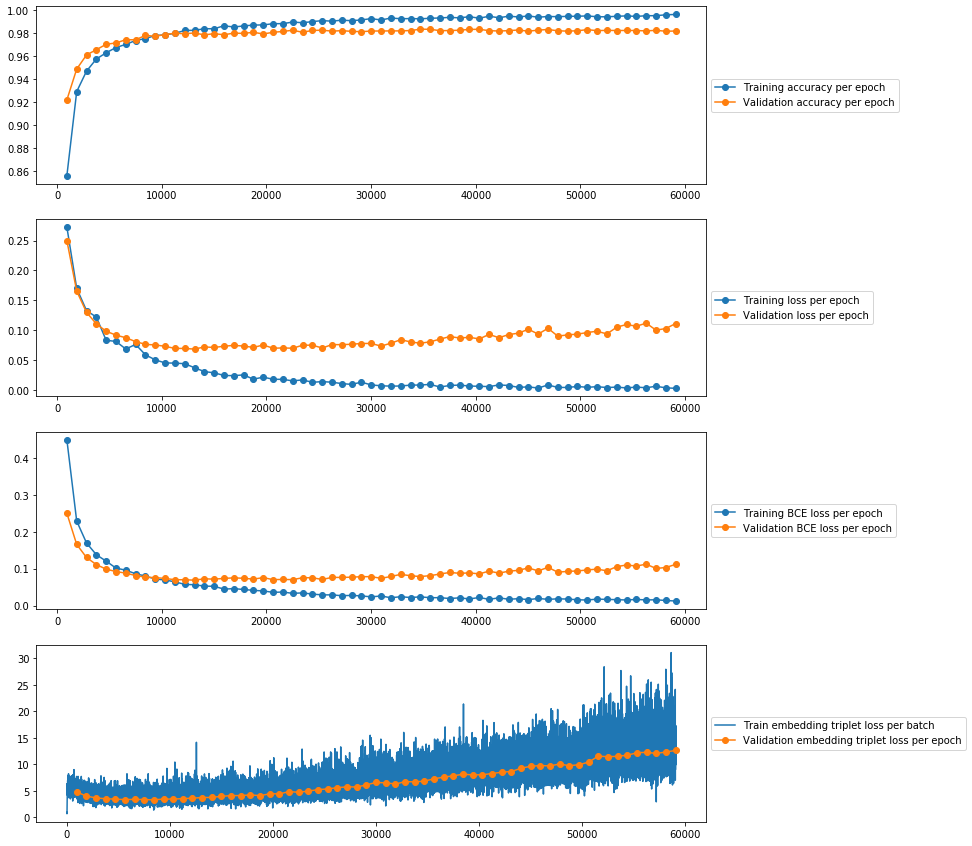

In [15]:
validator.plot()

In [27]:
model2 = SelectiveSequential(
    ['act4', 'act5', 'out'],
    {#'conv32a': nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
     #'batch32a': nn.BatchNorm2d(32),
     #'act32a': nn.ReLU(),
    
     #'conv32b': nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
     #'batch32b': nn.BatchNorm2d(32),
     #'act32b': nn.ReLU(),
     
     #'max1': nn.MaxPool2d(kernel_size=2, stride=2),
    
     #'conv64a': nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
     #'batch64a': nn.BatchNorm2d(64),
     #'act64a': nn.ReLU(),
     
     #'conv64b': nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
     #'batch64b': nn.BatchNorm2d(64),
     #'act64b': nn.ReLU(),
    
     #'max2': nn.MaxPool2d(kernel_size=2, stride=2),
    
     #'conv128a': nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
     #'batch128a': nn.BatchNorm2d(128),
     #'act128a': nn.ReLU(),
     
     #'conv128b': nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
     # 'batch128b': nn.BatchNorm2d(128),
     #'act128b': nn.ReLU(),
     
     # 'max3': nn.MaxPool2d(kernel_size=2, stride=2),
    
     'flatten': Flatten(),
    
     'fc1': nn.Linear(784, 100),
     'act1': nn.ReLU(),
     #'drop1': nn.Dropout(.05),
        
     'fc2': nn.Linear(100, 200),  
     'act2': nn.ReLU(),
        
     'fc3': nn.Linear(200, 200),  
     'act3': nn.ReLU(),
        
     'fc4': nn.Linear(200, 100),  
     'act4': nn.ReLU(),
        
     'fc5': nn.Linear(100, 50),  
     'act5': nn.ReLU(),
        
     #'drop1': nn.Dropout(.05),
     'out': nn.Linear(50, 10)})

In [28]:
criterion = TripletRegularizedCrossEntropyLoss(.1, 1)

In [29]:
sess = Session(model2, criterion, optim.Adam, 1e-3)

In [30]:
validator2 = EmbeddingSpaceValidator(valloader, 2, CustomOneHotAccuracy)
lr_scheduler2 = CosAnneal(len(trainloader), T_mult=1, lr_min=1e-6)
schedule2 = TrainingSchedule(trainloader, [lr_scheduler2, validator2])
sess.train(schedule2, 63)

Validating: 100%|██████████| 157/157 [00:02<00:00, 52.85it/s]


val accuracy:  0.9417 
train loss:  0.4791  train BCE :  0.5079 
valid loss:  0.4037  valid BCE :  0.2111


Validating: 100%|██████████| 157/157 [00:03<00:00, 52.09it/s]


val accuracy:  0.9569 
train loss:  0.279  train BCE :  0.2025 
valid loss:  0.2799  valid BCE :  0.1488


Validating: 100%|██████████| 157/157 [00:02<00:00, 52.80it/s]


val accuracy:  0.9626 
train loss:  0.2309  train BCE :  0.156 
valid loss:  0.2294  valid BCE :  0.124


Validating: 100%|██████████| 157/157 [00:03<00:00, 52.21it/s]


val accuracy:  0.9664 
train loss:  0.1839  train BCE :  0.1342 
valid loss:  0.199  valid BCE :  0.1104


Validating: 100%|██████████| 157/157 [00:02<00:00, 52.64it/s]


val accuracy:  0.9695 
train loss:  0.1625  train BCE :  0.12 
valid loss:  0.1776  valid BCE :  0.0987


Validating: 100%|██████████| 157/157 [00:02<00:00, 53.28it/s]


val accuracy:  0.9712 
train loss:  0.1453  train BCE :  0.1051 
valid loss:  0.1688  valid BCE :  0.0942


Validating: 100%|██████████| 157/157 [00:02<00:00, 53.36it/s]


val accuracy:  0.9736 
train loss:  0.116  train BCE :  0.0965 
valid loss:  0.1565  valid BCE :  0.0889


Validating: 100%|██████████| 157/157 [00:03<00:00, 52.17it/s]


val accuracy:  0.9739 
train loss:  0.1009  train BCE :  0.0876 
valid loss:  0.1476  valid BCE :  0.0838


Validating: 100%|██████████| 157/157 [00:02<00:00, 52.66it/s]


val accuracy:  0.974 
train loss:  0.1033  train BCE :  0.0816 
valid loss:  0.1422  valid BCE :  0.0819


Validating: 100%|██████████| 157/157 [00:03<00:00, 51.20it/s]


val accuracy:  0.9762 
train loss:  0.086  train BCE :  0.0758 
valid loss:  0.1383  valid BCE :  0.0804


Validating: 100%|██████████| 157/157 [00:03<00:00, 52.28it/s]


val accuracy:  0.9777 
train loss:  0.0893  train BCE :  0.0704 
valid loss:  0.1348  valid BCE :  0.078


Validating: 100%|██████████| 157/157 [00:02<00:00, 52.87it/s]


val accuracy:  0.978 
train loss:  0.0916  train BCE :  0.0709 
valid loss:  0.131  valid BCE :  0.0762


Validating: 100%|██████████| 157/157 [00:02<00:00, 52.63it/s]


val accuracy:  0.9785 
train loss:  0.0744  train BCE :  0.0644 
valid loss:  0.1256  valid BCE :  0.0735


Validating: 100%|██████████| 157/157 [00:02<00:00, 52.63it/s]


val accuracy:  0.9782 
train loss:  0.0753  train BCE :  0.0574 
valid loss:  0.1243  valid BCE :  0.0727


Validating: 100%|██████████| 157/157 [00:03<00:00, 51.88it/s]


val accuracy:  0.9776 
train loss:  0.0709  train BCE :  0.0602 
valid loss:  0.1245  valid BCE :  0.0738


Validating: 100%|██████████| 157/157 [00:02<00:00, 52.77it/s]


val accuracy:  0.9791 
train loss:  0.0611  train BCE :  0.0552 
valid loss:  0.1219  valid BCE :  0.0714


Validating: 100%|██████████| 157/157 [00:02<00:00, 52.70it/s]


val accuracy:  0.9813 
train loss:  0.0497  train BCE :  0.0539 
valid loss:  0.121  valid BCE :  0.0696


Validating: 100%|██████████| 157/157 [00:02<00:00, 52.74it/s]


val accuracy:  0.9787 
train loss:  0.0501  train BCE :  0.0502 
valid loss:  0.1284  valid BCE :  0.0743


Validating: 100%|██████████| 157/157 [00:02<00:00, 52.39it/s]


val accuracy:  0.9794 
train loss:  0.0368  train BCE :  0.0471 
valid loss:  0.1255  valid BCE :  0.0733


Validating: 100%|██████████| 157/157 [00:02<00:00, 52.76it/s]


val accuracy:  0.9795 
train loss:  0.0444  train BCE :  0.0459 
valid loss:  0.1264  valid BCE :  0.0743


Validating: 100%|██████████| 157/157 [00:02<00:00, 52.65it/s]


val accuracy:  0.9793 
train loss:  0.0433  train BCE :  0.0414 
valid loss:  0.1235  valid BCE :  0.0721


Validating: 100%|██████████| 157/157 [00:02<00:00, 52.83it/s]


val accuracy:  0.98 
train loss:  0.0414  train BCE :  0.042 
valid loss:  0.1221  valid BCE :  0.0718


Validating: 100%|██████████| 157/157 [00:02<00:00, 52.88it/s]


val accuracy:  0.9807 
train loss:  0.0378  train BCE :  0.0402 
valid loss:  0.1193  valid BCE :  0.0704


Validating: 100%|██████████| 157/157 [00:03<00:00, 52.09it/s]


val accuracy:  0.9807 
train loss:  0.0416  train BCE :  0.0376 
valid loss:  0.1217  valid BCE :  0.0716


Validating: 100%|██████████| 157/157 [00:02<00:00, 52.47it/s]


val accuracy:  0.9816 
train loss:  0.0279  train BCE :  0.0354 
valid loss:  0.1203  valid BCE :  0.07


Validating: 100%|██████████| 157/157 [00:02<00:00, 53.43it/s]


val accuracy:  0.981 
train loss:  0.0309  train BCE :  0.0362 
valid loss:  0.1221  valid BCE :  0.0711


Validating: 100%|██████████| 157/157 [00:02<00:00, 52.80it/s]


val accuracy:  0.9813 
train loss:  0.0324  train BCE :  0.0336 
valid loss:  0.1228  valid BCE :  0.0709


Validating: 100%|██████████| 157/157 [00:02<00:00, 52.61it/s]


val accuracy:  0.9818 
train loss:  0.0273  train BCE :  0.0325 
valid loss:  0.1198  valid BCE :  0.07


Validating: 100%|██████████| 157/157 [00:02<00:00, 52.66it/s]


val accuracy:  0.9813 
train loss:  0.0275  train BCE :  0.0327 
valid loss:  0.1255  valid BCE :  0.0727


Validating: 100%|██████████| 157/157 [00:03<00:00, 51.86it/s]


val accuracy:  0.9795 
train loss:  0.0291  train BCE :  0.0308 
valid loss:  0.1265  valid BCE :  0.0741


Validating: 100%|██████████| 157/157 [00:02<00:00, 52.38it/s]


val accuracy:  0.9795 
train loss:  0.0225  train BCE :  0.0289 
valid loss:  0.1267  valid BCE :  0.0729


Validating: 100%|██████████| 157/157 [00:02<00:00, 52.70it/s]


val accuracy:  0.9809 
train loss:  0.0234  train BCE :  0.0283 
valid loss:  0.1274  valid BCE :  0.0744


Validating: 100%|██████████| 157/157 [00:02<00:00, 52.74it/s]


val accuracy:  0.9806 
train loss:  0.0222  train BCE :  0.0269 
valid loss:  0.1268  valid BCE :  0.0737


Validating: 100%|██████████| 157/157 [00:02<00:00, 52.86it/s]


val accuracy:  0.9805 
train loss:  0.0195  train BCE :  0.0247 
valid loss:  0.1286  valid BCE :  0.0751


Validating: 100%|██████████| 157/157 [00:02<00:00, 53.27it/s]


val accuracy:  0.9795 
train loss:  0.0193  train BCE :  0.0261 
valid loss:  0.1342  valid BCE :  0.0793


Validating: 100%|██████████| 157/157 [00:02<00:00, 53.35it/s]


val accuracy:  0.9806 
train loss:  0.0167  train BCE :  0.0243 
valid loss:  0.1324  valid BCE :  0.0774


Validating: 100%|██████████| 157/157 [00:02<00:00, 53.68it/s]


val accuracy:  0.9799 
train loss:  0.0169  train BCE :  0.0249 
valid loss:  0.1344  valid BCE :  0.0784


Validating: 100%|██████████| 157/157 [00:02<00:00, 52.97it/s]


val accuracy:  0.9803 
train loss:  0.0188  train BCE :  0.023 
valid loss:  0.1299  valid BCE :  0.0773


Validating: 100%|██████████| 157/157 [00:02<00:00, 53.05it/s]


val accuracy:  0.98 
train loss:  0.0142  train BCE :  0.0249 
valid loss:  0.1342  valid BCE :  0.077


Validating: 100%|██████████| 157/157 [00:02<00:00, 53.05it/s]


val accuracy:  0.9798 
train loss:  0.0159  train BCE :  0.0223 
valid loss:  0.137  valid BCE :  0.0806


Validating: 100%|██████████| 157/157 [00:02<00:00, 53.63it/s]


val accuracy:  0.9797 
train loss:  0.0129  train BCE :  0.0216 
valid loss:  0.1295  valid BCE :  0.0756


Validating: 100%|██████████| 157/157 [00:02<00:00, 52.72it/s]


val accuracy:  0.9807 
train loss:  0.0162  train BCE :  0.0239 
valid loss:  0.1289  valid BCE :  0.0742


Validating: 100%|██████████| 157/157 [00:02<00:00, 53.74it/s]


val accuracy:  0.9807 
train loss:  0.0119  train BCE :  0.0207 
valid loss:  0.1362  valid BCE :  0.0791


Validating: 100%|██████████| 157/157 [00:02<00:00, 52.89it/s]


val accuracy:  0.9813 
train loss:  0.0127  train BCE :  0.0182 
valid loss:  0.13  valid BCE :  0.0762


Validating: 100%|██████████| 157/157 [00:02<00:00, 53.39it/s]


val accuracy:  0.9811 
train loss:  0.0182  train BCE :  0.0212 
valid loss:  0.134  valid BCE :  0.0771


Validating: 100%|██████████| 157/157 [00:02<00:00, 52.84it/s]


val accuracy:  0.9809 
train loss:  0.011  train BCE :  0.0196 
valid loss:  0.1406  valid BCE :  0.082


Validating: 100%|██████████| 157/157 [00:02<00:00, 53.47it/s]


val accuracy:  0.9787 
train loss:  0.0188  train BCE :  0.0157 
valid loss:  0.1493  valid BCE :  0.0871


Validating: 100%|██████████| 157/157 [00:02<00:00, 53.17it/s]


val accuracy:  0.9801 
train loss:  0.0142  train BCE :  0.0218 
valid loss:  0.1491  valid BCE :  0.0851


Validating: 100%|██████████| 157/157 [00:02<00:00, 53.54it/s]


val accuracy:  0.9802 
train loss:  0.0073  train BCE :  0.0166 
valid loss:  0.1448  valid BCE :  0.083


Validating: 100%|██████████| 157/157 [00:02<00:00, 53.62it/s]


val accuracy:  0.9805 
train loss:  0.0101  train BCE :  0.0172 
valid loss:  0.1447  valid BCE :  0.0841


Validating: 100%|██████████| 157/157 [00:02<00:00, 53.33it/s]


val accuracy:  0.9804 
train loss:  0.0142  train BCE :  0.0188 
valid loss:  0.1458  valid BCE :  0.0835


Validating: 100%|██████████| 157/157 [00:02<00:00, 52.95it/s]


val accuracy:  0.9796 
train loss:  0.016  train BCE :  0.0166 
valid loss:  0.1533  valid BCE :  0.087


Validating: 100%|██████████| 157/157 [00:02<00:00, 53.52it/s]


val accuracy:  0.9824 
train loss:  0.0087  train BCE :  0.0156 
valid loss:  0.1401  valid BCE :  0.0813


Validating: 100%|██████████| 157/157 [00:02<00:00, 53.10it/s]


val accuracy:  0.9793 
train loss:  0.013  train BCE :  0.0163 
valid loss:  0.1557  valid BCE :  0.0896


Validating: 100%|██████████| 157/157 [00:02<00:00, 53.06it/s]


val accuracy:  0.979 
train loss:  0.0073  train BCE :  0.0133 
valid loss:  0.1548  valid BCE :  0.0891


Validating: 100%|██████████| 157/157 [00:02<00:00, 53.62it/s]


val accuracy:  0.9812 
train loss:  0.0091  train BCE :  0.0167 
valid loss:  0.1429  valid BCE :  0.0803


Validating: 100%|██████████| 157/157 [00:02<00:00, 53.59it/s]


val accuracy:  0.9808 
train loss:  0.009  train BCE :  0.0109 
valid loss:  0.1515  valid BCE :  0.0861


Validating: 100%|██████████| 157/157 [00:02<00:00, 53.20it/s]


val accuracy:  0.98 
train loss:  0.0135  train BCE :  0.0204 
valid loss:  0.1481  valid BCE :  0.082


Validating: 100%|██████████| 157/157 [00:02<00:00, 53.33it/s]


val accuracy:  0.9801 
train loss:  0.0094  train BCE :  0.0146 
valid loss:  0.1549  valid BCE :  0.0857


Validating: 100%|██████████| 157/157 [00:02<00:00, 53.35it/s]


val accuracy:  0.9812 
train loss:  0.0075  train BCE :  0.0153 
valid loss:  0.153  valid BCE :  0.0868


Validating: 100%|██████████| 157/157 [00:02<00:00, 53.46it/s]


val accuracy:  0.9797 
train loss:  0.0101  train BCE :  0.0127 
valid loss:  0.1565  valid BCE :  0.0878


Validating: 100%|██████████| 157/157 [00:02<00:00, 53.15it/s]


val accuracy:  0.9794 
train loss:  0.0084  train BCE :  0.0139 
valid loss:  0.1655  valid BCE :  0.0934


Validating: 100%|██████████| 157/157 [00:02<00:00, 53.12it/s]


val accuracy:  0.9808 
train loss:  0.007  train BCE :  0.0131 
valid loss:  0.1626  valid BCE :  0.0924



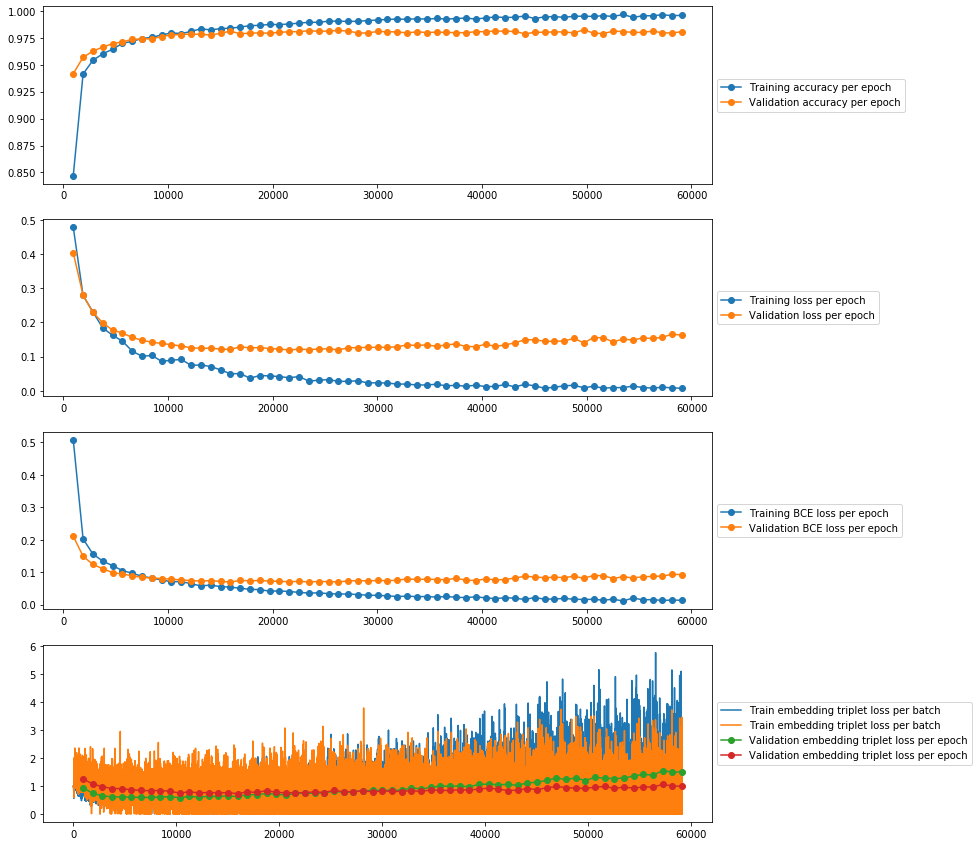

In [31]:
validator2.plot()

In [32]:
np.max(validator2.val_accuracies), "Best accuracy with reg"

(0.9824, 'Best accuracy with reg')

In [33]:
np.max(validator.val_accuracies), "Best accuracy without reg"

(0.9836, 'Best accuracy without reg')